# Selection when there are many random features

This notebook includes a comparison of feature selection methods when there are more irrelevant features then there are informative ones. The discussion closely follows that of *FeatureSelection.ipynb*.

In [2]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
from itertools import product, combinations
import warnings

# sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import ParameterGrid, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.datasets import make_classification

# Selectors
from utils.selectors import *

import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter('ignore')

%matplotlib inline

# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 10})
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

Create synthetic data with many random features (unlrelated to outcome)

In [2]:
# Create synthetic data
X, y = make_classification(n_samples=1000, n_features=75, n_informative=5, n_redundant=5, n_classes=2, 
                           n_clusters_per_class=2, class_sep=1.0, flip_y = 0.005, random_state=1234)

# Create training and test split (half of samples in test set)
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.5,stratify = y, random_state=12345)

# As dataframe
n_feats = 75
df_tr = pd.DataFrame(X_tr, columns=['f-'+str(i+1) for i in range(n_feats)])
df_tr['label'] = y_tr

df_ts = pd.DataFrame(X_ts, columns=['f-'+str(i+1) for i in range(n_feats)])
df_ts['label'] = y_ts

We have only 5 informative features, and 5 redundant linear combinations of them. The rest of the features are random noise.

### Univariate analysis

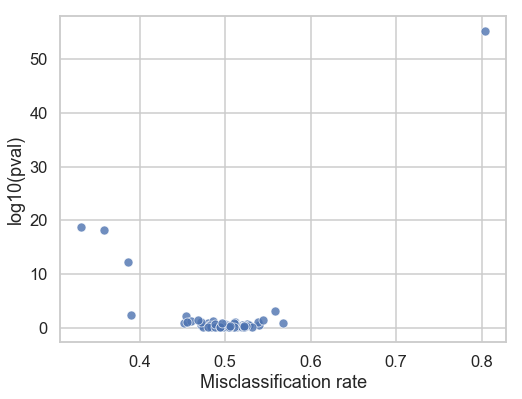

In [3]:
# Effect sizes and p-values from training data
df_v = volcano(df_tr)

fig = plt.figure(figsize=(8,6))
df_v['log10p'] = df_v['pval'].apply(lambda x: -np.log10(x))

sns.scatterplot(data=df_v, x='mc_rate', y='log10p', alpha=0.8)
plt.xlabel('Misclassification rate')
plt.ylabel('log10(pval)')
plt.show()

From the univariate analysis, there seem to be around 4 features with low overlap (misclassification rate) that have low p-values. The smallest p-value feature have a large overlap, and may not be relevant.

In [4]:
df_v.sort_values('pval').head(5)

,pval,mc_rate,log10p
f-70,5.054809e-56,0.804,55.296295
f-32,1.690769e-19,0.332,18.771916
f-48,7.056951e-19,0.358,18.151383
f-45,7.455233e-13,0.386,12.127539
f-67,8.456629e-04,0.558,3.072803


### Ridge Regression

Use all features in ridge regression:

In [8]:
skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l2', scoring = 'neg_log_loss',
                             n_jobs=-1)
clf_cv.fit(X_tr, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a1998ee48>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
# Predict
y_prob_tr = clf_cv.predict_proba(X_tr)
y_prob_ts = clf_cv.predict_proba(X_ts)

In [10]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3038 :: Test NLL = -0.5102
Train AUC = 0.9511 :: Test AUC = 0.8344


In [11]:
# Save weights
weights_ridge = np.squeeze(clf_cv.coef_)

### LASSO

Use all features in LASSO:

In [12]:
skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l1', scoring = 'neg_log_loss',
                              solver = 'liblinear', n_jobs=-1)
clf_cv.fit(X_tr, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a1a0735c0>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [13]:
# Predict
y_prob_tr = clf_cv.predict_proba(X_tr)
y_prob_ts = clf_cv.predict_proba(X_ts)

In [14]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3189 :: Test NLL = -0.5000
Train AUC = 0.9413 :: Test AUC = 0.8445


In [16]:
weights_lasso = np.squeeze(clf_cv.coef_)
mask = weights_lasso != 0
selected_features_lasso = ['f-' + str(i+1) for i,c in enumerate(weights_lasso) if mask[i] !=0]
print("Number of selected features = {:d}".format(len(selected_features_lasso)))

Number of selected features = 25


### Forward Selection

Test forward selection on synthetic data

In [17]:
feature_list = ['f-'+str(i+1) for i in range(n_feats)]
rep_ridge = forward_select_ridge(df_tr, feature_list, Cs = np.logspace(-4,1,20), n_max=30)

Selected feature = f-70 :: best C = 0.4833 :: current CV score = -0.4391
Selected feature = f-47 :: best C = 0.8859 :: current CV score = -0.3966
Selected feature = f-75 :: best C = 0.8859 :: current CV score = -0.3696
Selected feature = f-13 :: best C = 0.8859 :: current CV score = -0.3589
Selected feature = f-23 :: best C = 0.8859 :: current CV score = -0.3522
Selected feature = f-74 :: best C = 0.8859 :: current CV score = -0.3483
Selected feature = f-20 :: best C = 0.8859 :: current CV score = -0.3457
Selected feature = f-1 :: best C = 0.8859 :: current CV score = -0.3436
Selected feature = f-65 :: best C = 0.8859 :: current CV score = -0.3422
Selected feature = f-57 :: best C = 0.8859 :: current CV score = -0.3409
Selected feature = f-46 :: best C = 0.8859 :: current CV score = -0.3400
Selected feature = f-62 :: best C = 0.4833 :: current CV score = -0.3387
Selected feature = f-40 :: best C = 0.4833 :: current CV score = -0.3376
Selected feature = f-16 :: best C = 0.4833 :: curren

From the log, we can see that the CV scores start to decrease after a while. Let's find the maximum position to determine the best set of features and C (optimized together):

In [18]:
nlls_forward = [sc for f,c,sc in rep_ridge]
feat_lists = [f for f,c,sc in rep_ridge]

idx_best = np.argmax(nlls_forward)
selected_features_forward = feat_lists[idx_best]
print("{:d}/{:d} features chosen".format(len(selected_features_forward),n_feats))

25/75 features chosen


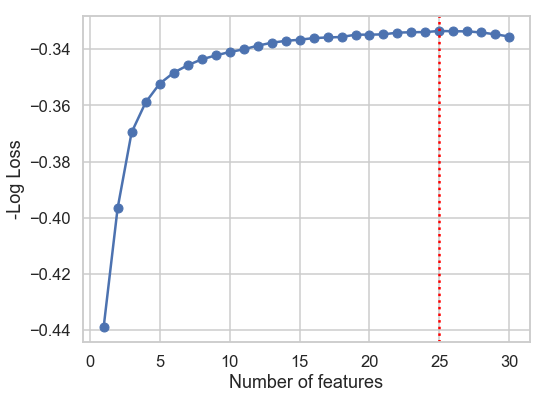

In [19]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(1,31), nlls_forward, 'b-o')
plt.axvline(25, color='red', linestyle = ':')
plt.xlabel('Number of features')
plt.ylabel('-Log Loss')
plt.show()

Refit with the determined hyper-parameters and evaluate performance.

In [20]:
# Refit using best hyper-parameters
f_list_sk, c_best, _ = rep_ridge[idx_best]

xx_tr = df_tr[f_list_sk]
xx_ts = df_ts[f_list_sk]
clf_fin = LogisticRegression(C=c_best, penalty='l2')
clf_fin.fit(xx_tr, y_tr)

# Predict
y_prob_tr = clf_fin.predict_proba(xx_tr)
y_prob_ts = clf_fin.predict_proba(xx_ts)

In [21]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.2944 :: Test NLL = -0.5878
Train AUC = 0.9482 :: Test AUC = 0.8235


In [22]:
# Forward selection weights
weights_forward = np.squeeze(clf_fin.coef_)

### Selection of Features by tree ensembles

In [23]:
# Extra trees for Feature selection
rf = RandomForestClassifier(n_estimators=500, max_features=10, n_jobs=-1)
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
# Select features
selector = SelectFromModel(rf, prefit=True)
X_tr_new = selector.transform(X_tr)
X_ts_new = selector.transform(X_ts)

mask = list(selector.get_support())
selected_features_rf = [f for i,f in enumerate(range(n_feats)) if mask[i] == True]
selected_features_rf = list(map(lambda x: 'f-' + str(x), selected_features_rf))
print("Number of selected features = {:d}".format(len(selected_features_rf)))

Number of selected features = 10


Now that we have selected the features, let's use them to train a separate ridge regression classifier.

In [26]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12345)
clf = LogisticRegressionCV(Cs = np.logspace(-4,1,20), penalty='l2', cv=skf, scoring='neg_log_loss', n_jobs=-1)
clf.fit(X_tr_new, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a19909470>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [27]:
# Predict
y_prob_tr = clf.predict_proba(X_tr_new)
y_prob_ts = clf.predict_proba(X_ts_new)

# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3489 :: Test NLL = -0.4856
Train AUC = 0.9252 :: Test AUC = 0.8558


In [28]:
weights_rf_ridge = np.squeeze(clf.coef_)

Visualizing all selected features:

## Comparison

Let's compare which features are selected from each procedure:

In [32]:
# Visualize all weights from different models together
ser_ridge = pd.Series(weights_ridge, index = df_tr.columns.tolist()[:-1])
ser_lasso = pd.Series(weights_lasso, index = df_tr.columns.tolist()[:-1])
ser_forward = pd.Series(weights_forward, index = selected_features_forward)
ser_rf = pd.Series(weights_rf_ridge, index = selected_features_rf)

# Rescale
ser_ridge = ser_ridge / (ser_ridge.max() - ser_ridge.min())
ser_lasso = ser_lasso / (ser_lasso.max() - ser_lasso.min())
ser_forward = ser_forward / (ser_forward.max() - ser_forward.min())
ser_rf = ser_rf / (ser_rf.max() - ser_rf.min())

all_w = pd.DataFrame(index=df_tr.columns.tolist()[:-1])
all_w['ridge'] = ser_ridge
all_w['lasso'] = ser_lasso
all_w['forward'] = ser_forward
all_w['RF+Ridge'] = ser_rf
all_w = all_w.fillna(0)

Let's plot the features as a heatmap

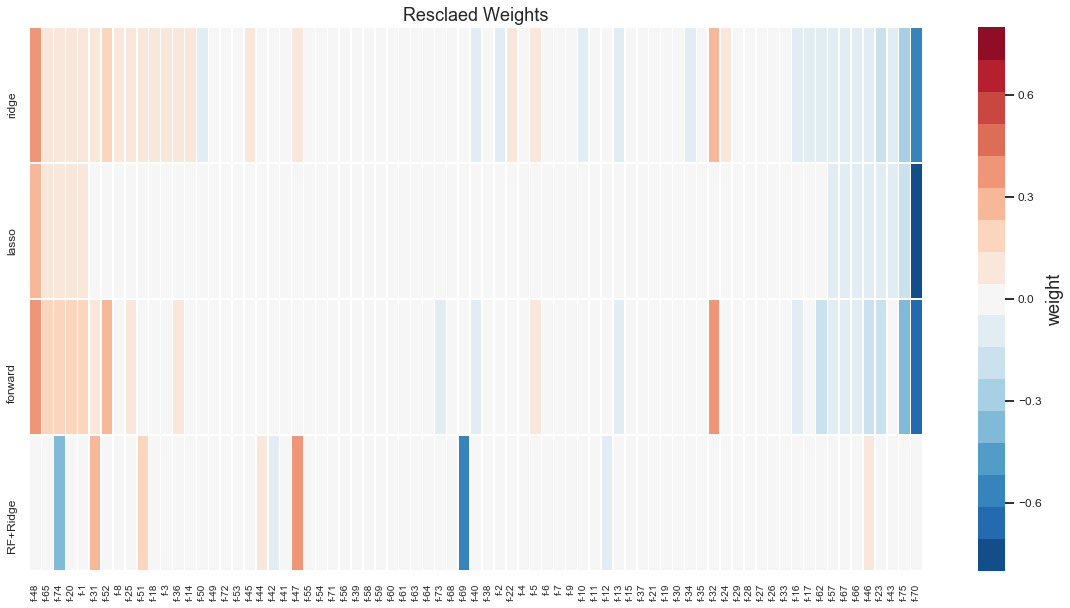

In [33]:
plt.rc('ytick', labelsize=12)
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=10)
df_ = all_w.sort_values('lasso', ascending=False).T

cmap = sns.color_palette("RdBu_r", 17)
sns.heatmap(df_, cmap=cmap, annot=False, linewidths=.5, cbar_kws={'label': 'weight'}, vmax=0.8, vmin=-0.8)
plt.title('Resclaed Weights')
plt.show()